In [2]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import pandas as pd

f = "/data/jlai/iris-hep/output100/estimatedparams.root"
file = uproot.open(f)
t = file['estimatedparams']
t.keys()

['event_nr',
 'volumeId',
 'layerId',
 'surfaceId',
 'loc0',
 'loc1',
 'phi',
 'theta',
 'qop',
 'time',
 'err_loc0',
 'err_loc1',
 'err_phi',
 'err_theta',
 'err_qop',
 'err_time',
 'charge',
 'p',
 'pt',
 'eta',
 'truthMatched',
 'particleId',
 'nMajorityHits',
 'particleId',
 't_loc0',
 't_loc1',
 't_phi',
 't_theta',
 't_qop',
 't_time',
 't_charge',
 't_p',
 't_pt',
 't_eta',
 'res_loc0',
 'res_loc1',
 'res_phi',
 'res_theta',
 'res_qop',
 'res_time',
 'pull_loc0',
 'pull_loc1',
 'pull_phi',
 'pull_theta',
 'pull_qop',
 'pull_time']

In [1]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

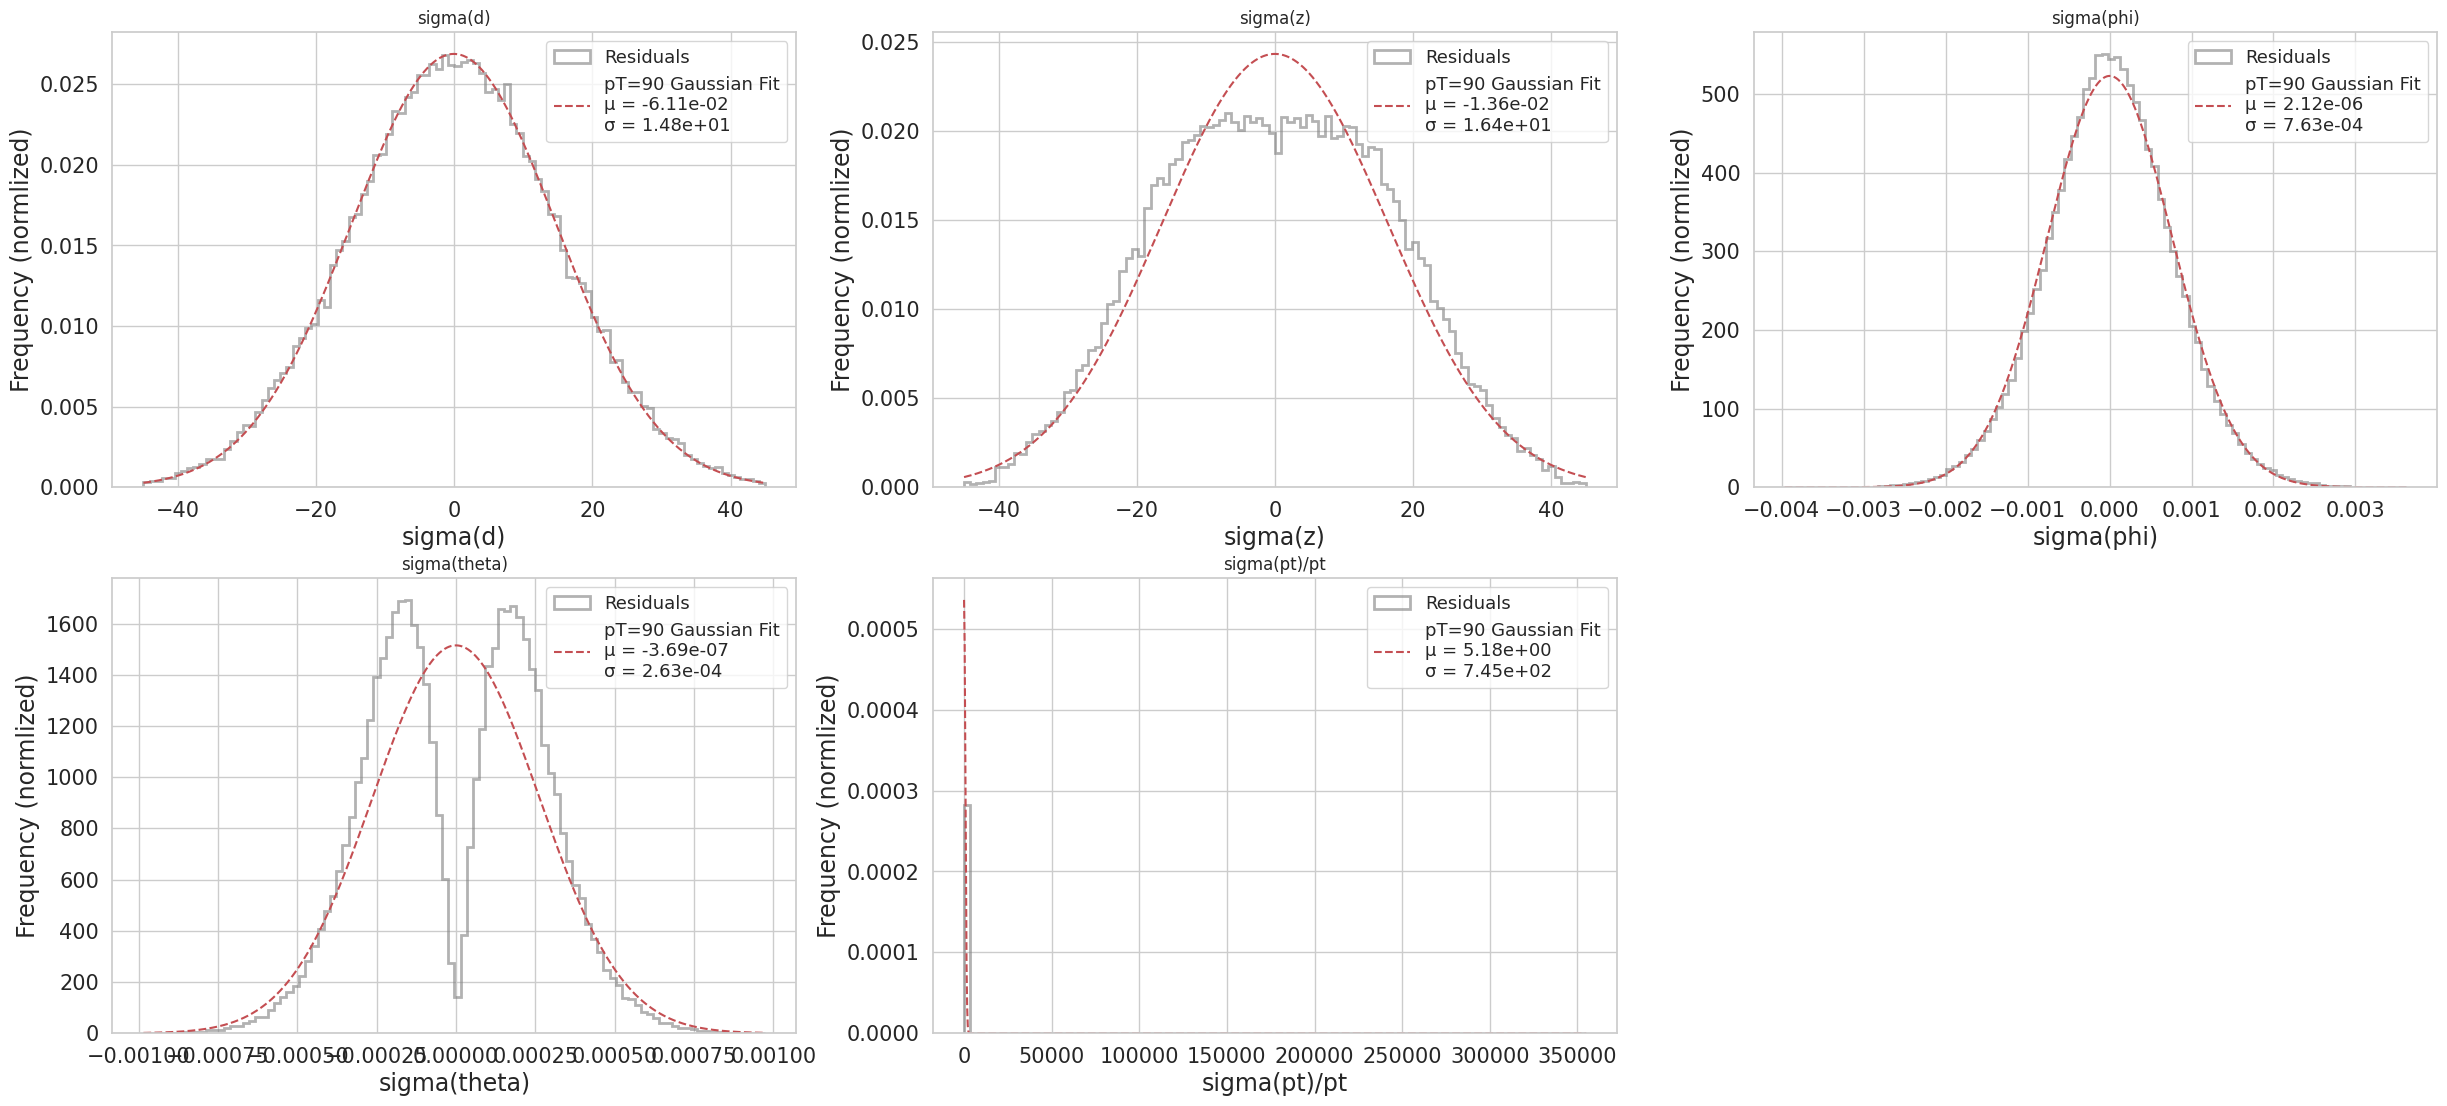

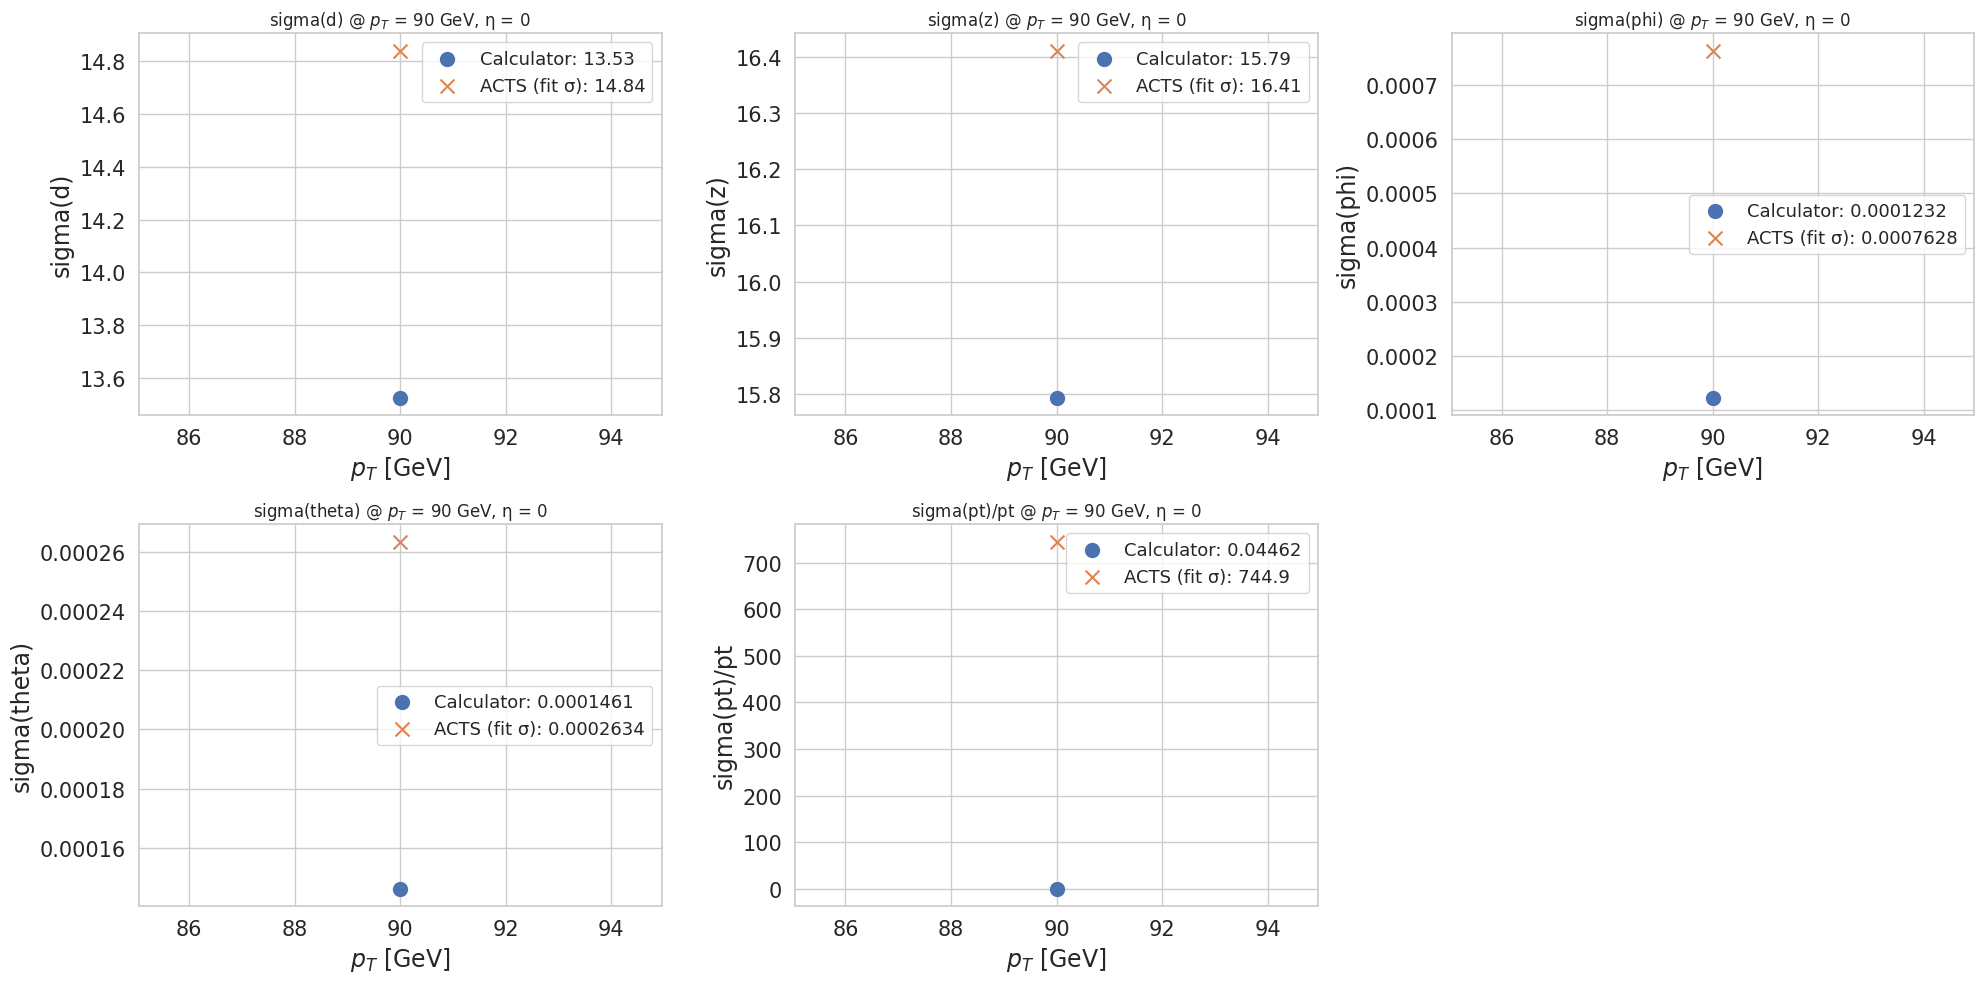

In [2]:
path = '/data/jlai/iris-hep/OutputPT/'
pT_values = np.arange(10, 100, 10)
i = -1
file = uproot.open(path + f'output_pt_{pT_values[i]}' + '/estimatedparams.root')

tree = file['estimatedparams']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_loc0", "loc0", "res_loc0", "pull_loc0",
                      "t_loc1", "loc1", "res_loc1", "pull_loc1",
                      "t_phi", "phi", "res_phi", "pull_phi",
                      "t_theta", "theta", "res_theta", "pull_theta",
                      "t_p", "qop", "res_qop", "pull_qop",
                      "t_charge", "t_pt"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['qop'] ) * np.sin(arrays['theta'])

labels = {
    'sigma(d)': (arrays['res_loc0']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': (arrays['res_loc1']) * 1e3, # converting to unit um
    'sigma(phi)': (arrays['res_phi']),
    'sigma(theta)': (arrays['res_theta']),
    'sigma(pt)/pt': ((pT_reco - pT_truth) / pT_truth)
}

fit_results = {}
plt.figure(figsize=(30, 13))
for key, data in labels.items():
    data = ak.to_numpy(data)
    data = data[~np.isnan(data)]

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma
    
    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'pT={pT_values[i]} Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.title(key)
    plt.xlabel(key)
    plt.ylabel("Frequency (normlized)")
    plt.legend()
    plt.grid(True)
plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
p, eta = pT_values[i], 0
B, m = 2, 0.106
path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
mydetector = inputfromfile(path+'ODD.txt', 0)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# < -- plot comparsion -- >
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    key = var_label
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

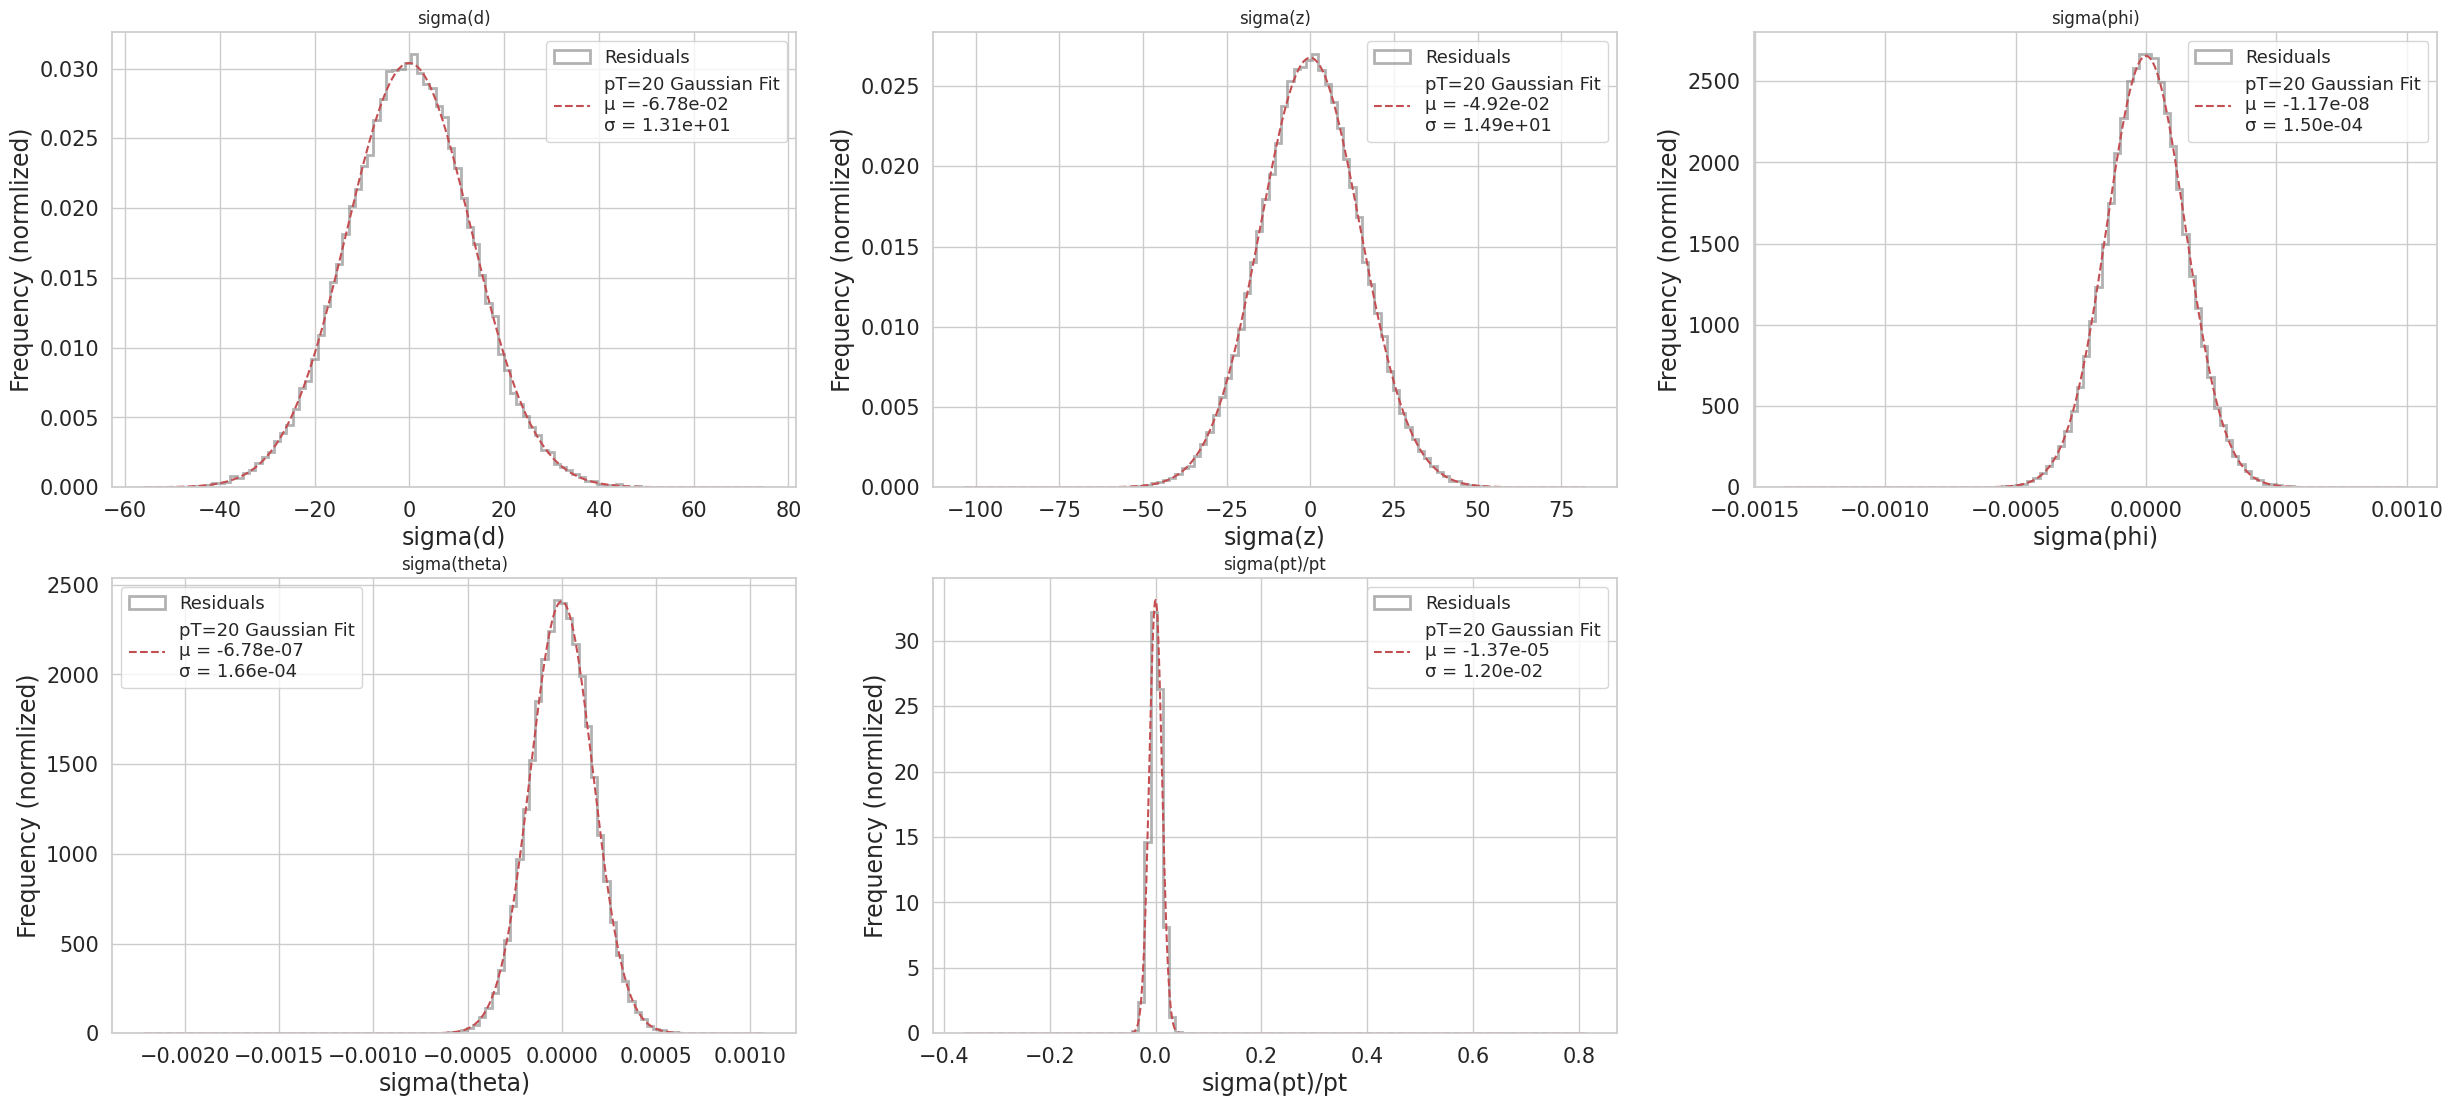

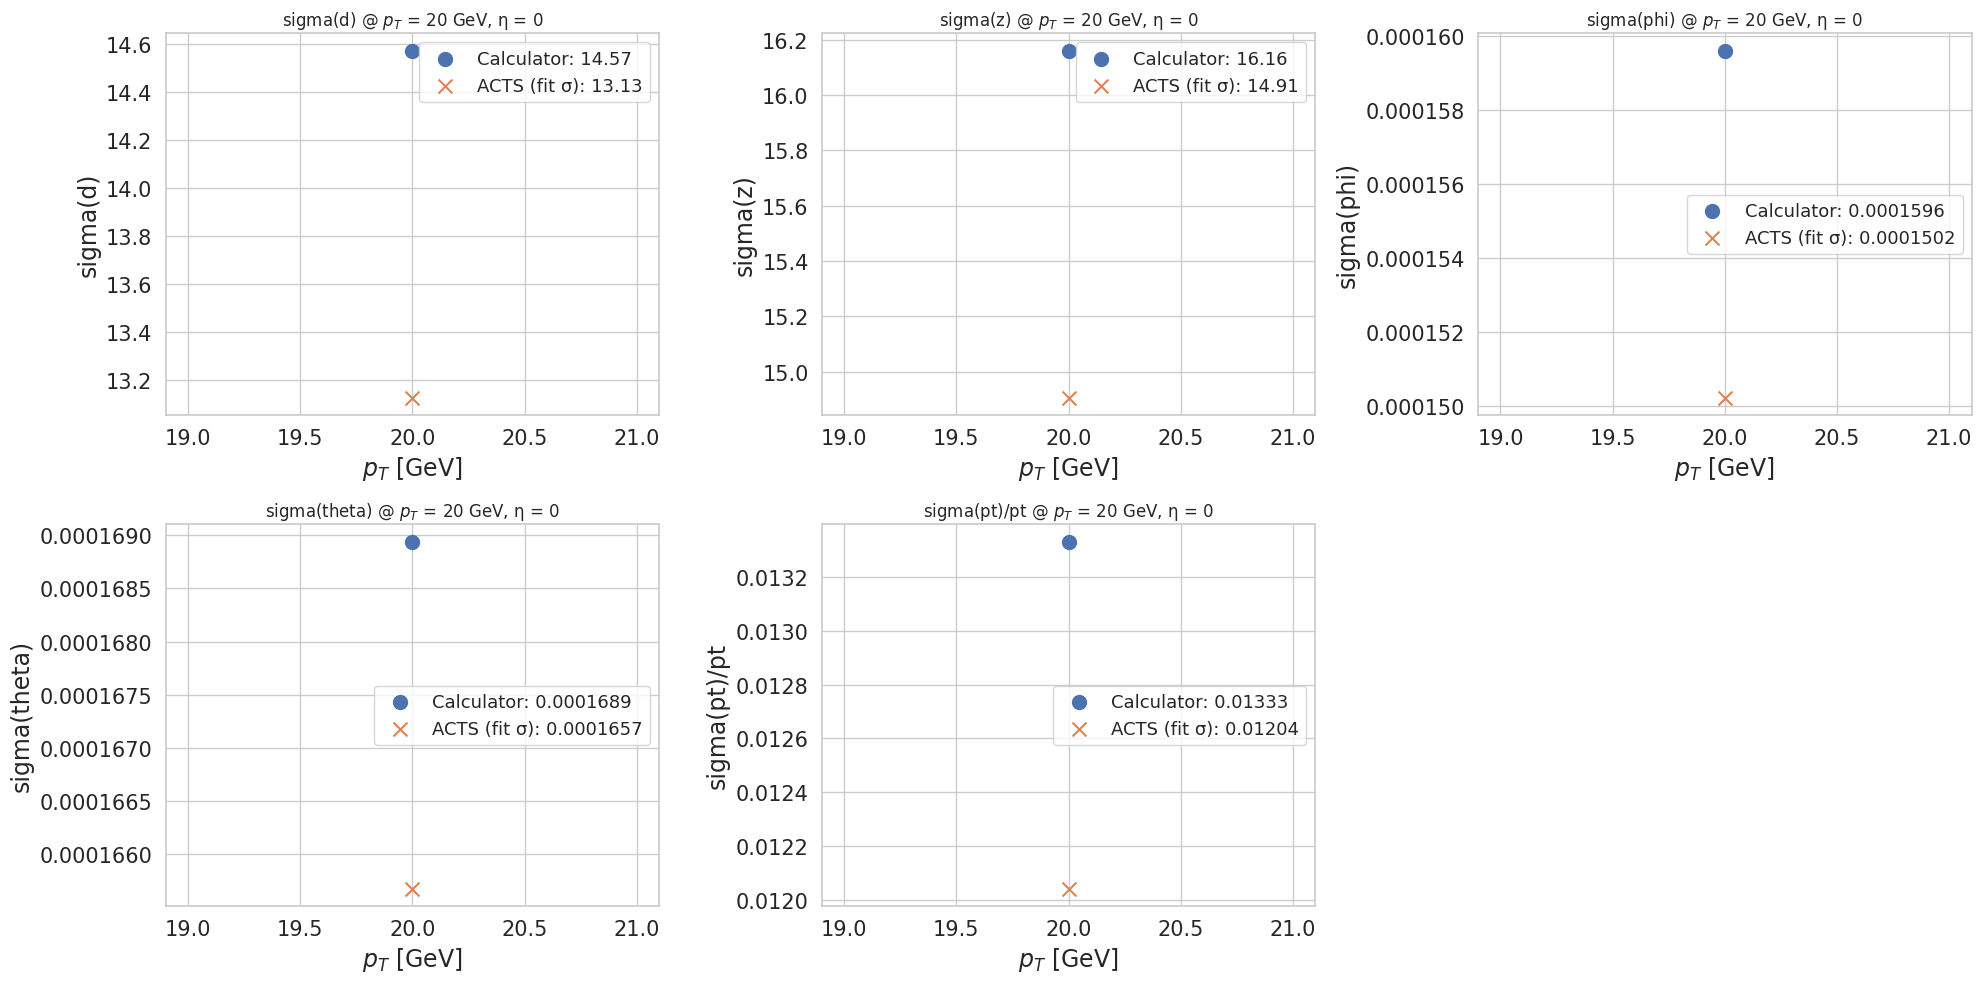

In [3]:
path = '/data/jlai/iris-hep/OutputPT/'
# pT_values = [1, 3, 5, 10]
pT_values = np.arange(10, 100, 10)
i = 1
file = uproot.open(path + f'output_pt_{pT_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit", "pull_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit", "pull_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit", "pull_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit", "pull_eTHETA_fit",
                      "t_p", "eQOP_fit", "res_eQOP_fit", "pull_eQOP_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth) / pT_truth)
}

fit_results = {}
plt.figure(figsize=(30, 13))
for key, data in labels.items():
    data = ak.to_numpy(data)
    data = data[~np.isnan(data)]

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma
    
    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'pT={pT_values[i]} Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.title(key)
    plt.xlabel(key)
    plt.ylabel("Frequency (normlized)")
    plt.legend()
    plt.grid(True)
plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
p, eta = pT_values[i], 0
B, m = 2, 0.106
path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
mydetector = inputfromfile(path+'ODD.txt', 0)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# < -- plot comparsion -- >
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    key = var_label
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
import os, math
import numpy as np
import uproot, awkward as ak
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

def has_field(obj, name):
    return (isinstance(obj, dict) and name in obj) or (hasattr(obj, "fields") and name in obj.fields)

def get_field(obj, name):
    return obj[name] if isinstance(obj, dict) else obj[name]

def arr_np(x):
    """flatten awkward → numpy and drop NaNs/inf"""
    if isinstance(x, ak.Array):
        x = ak.flatten(x, axis=None)
        x = ak.to_numpy(x)
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    return x

def wrap_delta_angle(d):
    d = np.asarray(d)
    return (d + np.pi) % (2*np.pi) - np.pi

def robust_norm_fit(x, do_truncate=True, iters=2):
    """Iterative ±3σ truncation then MLE (norm.fit). Returns (mu, sigma, N_used)."""
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return (np.nan, np.nan, 0)
    data = x.copy()
    if do_truncate:
        for _ in range(iters):
            mu, sd = np.mean(data), np.std(data, ddof=1)
            if not np.isfinite(sd) or sd == 0:
                break
            keep = (data >= mu - 3*sd) & (data <= mu + 3*sd)
            if keep.sum() < 10:
                break
            data = data[keep]
    mu, sigma = norm.fit(data)
    return mu, sigma, data.size

def common_hist_range(a, b, q=(0.001, 0.999)):
    """Shared range from combined quantiles (suppresses long tails/outliers)."""
    if a.size and b.size:
        x = np.concatenate([a, b])
    else:
        x = a if a.size else b
    if x.size == 0:
        return (-1, 1)
    lo, hi = np.nanquantile(x, q)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = x.min(), x.max()
        if lo == hi:
            lo, hi = lo - 1, hi + 1
    return float(lo), float(hi)

def find_tree(f, preferred=()):
    keys = list(f.keys())
    for name in preferred:
        if name in keys: return name
        if (name + ";1") in keys: return name + ";1"
    for k in keys:
        try:
            obj = f[k]
            if hasattr(obj, "num_entries"):
                return k
        except Exception:
            pass
    raise RuntimeError("No TTree found.")


# <<< EDIT THESE >>>
CKF_ROOT = "/data/jlai/iris-hep/OutputPT/output_pt_10/tracksummary_ckf.root"
EST_ROOT = "/data/jlai/iris-hep/OutputPT/output_pt_10/estimatedparams.root"

TRUTH_MATCHED_ONLY = True
NBINS = 100  # histogram bins
OUTDIR = None  # or a folder path to also save PNGs

# Optional fixed ranges (comment out or tweak)
FIXED_RANGES = {
    # "sigma(d)": (-50, 50),     # µm
    # "sigma(z)": (-100, 100),   # µm
    # "sigma(phi)": (-0.02, 0.02),
    # "sigma(theta)": (-0.002, 0.002),
    "sigma(pt)/pt": (-1, 1),
}

TITLES = {
    "sigma(d)": r"$\sigma(d)$  (µm)",
    "sigma(z)": r"$\sigma(z)$  (µm)",
    "sigma(phi)": r"$\sigma(\phi)$",
    "sigma(theta)": r"$\sigma(\theta)$",
    "sigma(pt)/pt": r"$\sigma(p_T)/p_T$",
}


def load_ckf(path, tree_name="tracksummary", truth_match=False):
    with uproot.open(path) as f:
        tname = find_tree(f, preferred=(tree_name,))
        t = f[tname]
        cols = [c for c in [
            "res_eLOC0_fit","res_eLOC1_fit","res_ePHI_fit","res_eTHETA_fit",
            "eQOP_fit","eTHETA_fit","t_p","t_theta","t_pt","truthMatched"
        ] if c in t.keys()]
        arr = t.arrays(cols, library="ak")

    if truth_match and has_field(arr, "truthMatched"):
        m = (arr["truthMatched"] == 1)
        arr = {k: arr[k][m] for k in arr.fields}

    # Residuals (loc are in mm → convert to µm)
    res_d   = arr_np(arr["res_eLOC0_fit"]) * 1e3 if has_field(arr,"res_eLOC0_fit") else np.array([])
    res_z   = arr_np(arr["res_eLOC1_fit"]) * 1e3 if has_field(arr,"res_eLOC1_fit") else np.array([])
    res_phi = arr_np(arr["res_ePHI_fit"]) if has_field(arr,"res_ePHI_fit") else np.array([])
    res_phi = wrap_delta_angle(res_phi) if res_phi.size else res_phi
    res_th  = arr_np(arr["res_eTHETA_fit"]) if has_field(arr,"res_eTHETA_fit") else np.array([])

    # Fractional pT residual: ((pT_rec - pT_true)/pT_true)
    pt_true = arr["t_pt"] if has_field(arr,"t_pt") else (arr["t_p"]*np.sin(arr["t_theta"]) if (has_field(arr,"t_p") and has_field(arr,"t_theta")) else None)
    if has_field(arr, "eQOP_fit"):
        p_rec = abs(1.0/arr["eQOP_fit"])
        theta_rec = arr["eTHETA_fit"] if has_field(arr,"eTHETA_fit") else (arr["t_theta"] if has_field(arr,"t_theta") else None)
        pt_rec = p_rec * np.sin(theta_rec) if theta_rec is not None else None
    else:
        pt_rec = None
    if (pt_true is not None) and (pt_rec is not None):
        frac_pt = arr_np((pt_rec - pt_true) / pt_true)
    else:
        frac_pt = np.array([])

    return {
        "sigma(d)": res_d,
        "sigma(z)": res_z,
        "sigma(phi)": res_phi,
        "sigma(theta)": res_th,
        "sigma(pt)/pt": frac_pt,
    }

def load_est(path, preferred_tree=("estimatedparams","estimatedparams;1"), truth_match=False):
    with uproot.open(path) as f:
        tname = find_tree(f, preferred=preferred_tree)
        t = f[tname]
        cols = [c for c in [
            "res_loc0","res_loc1","res_phi","res_theta",
            "qop","theta","pt","t_p","t_theta","t_pt","truthMatched"
        ] if c in t.keys()]
        arr = t.arrays(cols, library="ak")

    if truth_match and has_field(arr, "truthMatched"):
        m = (arr["truthMatched"] == 1)
        arr = {k: arr[k][m] for k in arr.fields}

    res_d   = arr_np(arr["res_loc0"]) * 1e3 if has_field(arr,"res_loc0") else np.array([])
    res_z   = arr_np(arr["res_loc1"]) * 1e3 if has_field(arr,"res_loc1") else np.array([])
    res_phi = arr_np(arr["res_phi"]) if has_field(arr,"res_phi") else np.array([])
    res_phi = wrap_delta_angle(res_phi) if res_phi.size else res_phi
    res_th  = arr_np(arr["res_theta"]) if has_field(arr,"res_theta") else np.array([])

    pt_true = arr["t_pt"] if has_field(arr,"t_pt") else (arr["t_p"]*np.sin(arr["t_theta"]) if (has_field(arr,"t_p") and has_field(arr,"t_theta")) else None)
    if has_field(arr,"pt"):
        pt_rec = arr["pt"]
    else:
        if has_field(arr,"qop") and has_field(arr,"theta"):
            p_rec = abs(1.0/arr["qop"])
            pt_rec = p_rec * np.sin(arr["theta"])
        else:
            pt_rec = None
    if (pt_true is not None) and (pt_rec is not None):
        frac_pt = arr_np((pt_rec - pt_true) / pt_true)
    else:
        frac_pt = np.array([])

    return {
        "sigma(d)": res_d,
        "sigma(z)": res_z,
        "sigma(phi)": res_phi,
        "sigma(theta)": res_th,
        "sigma(pt)/pt": frac_pt,
    }


In [20]:
data_ckf = load_ckf(CKF_ROOT, truth_match=TRUTH_MATCHED_ONLY)
data_est = load_est(EST_ROOT, truth_match=TRUTH_MATCHED_ONLY)

{k: (len(data_ckf[k]), len(data_est[k])) for k in data_ckf}  # quick size check


{'sigma(d)': (92045, 302021),
 'sigma(z)': (92045, 302021),
 'sigma(phi)': (92045, 302021),
 'sigma(theta)': (92045, 302021),
 'sigma(pt)/pt': (92045, 302021)}

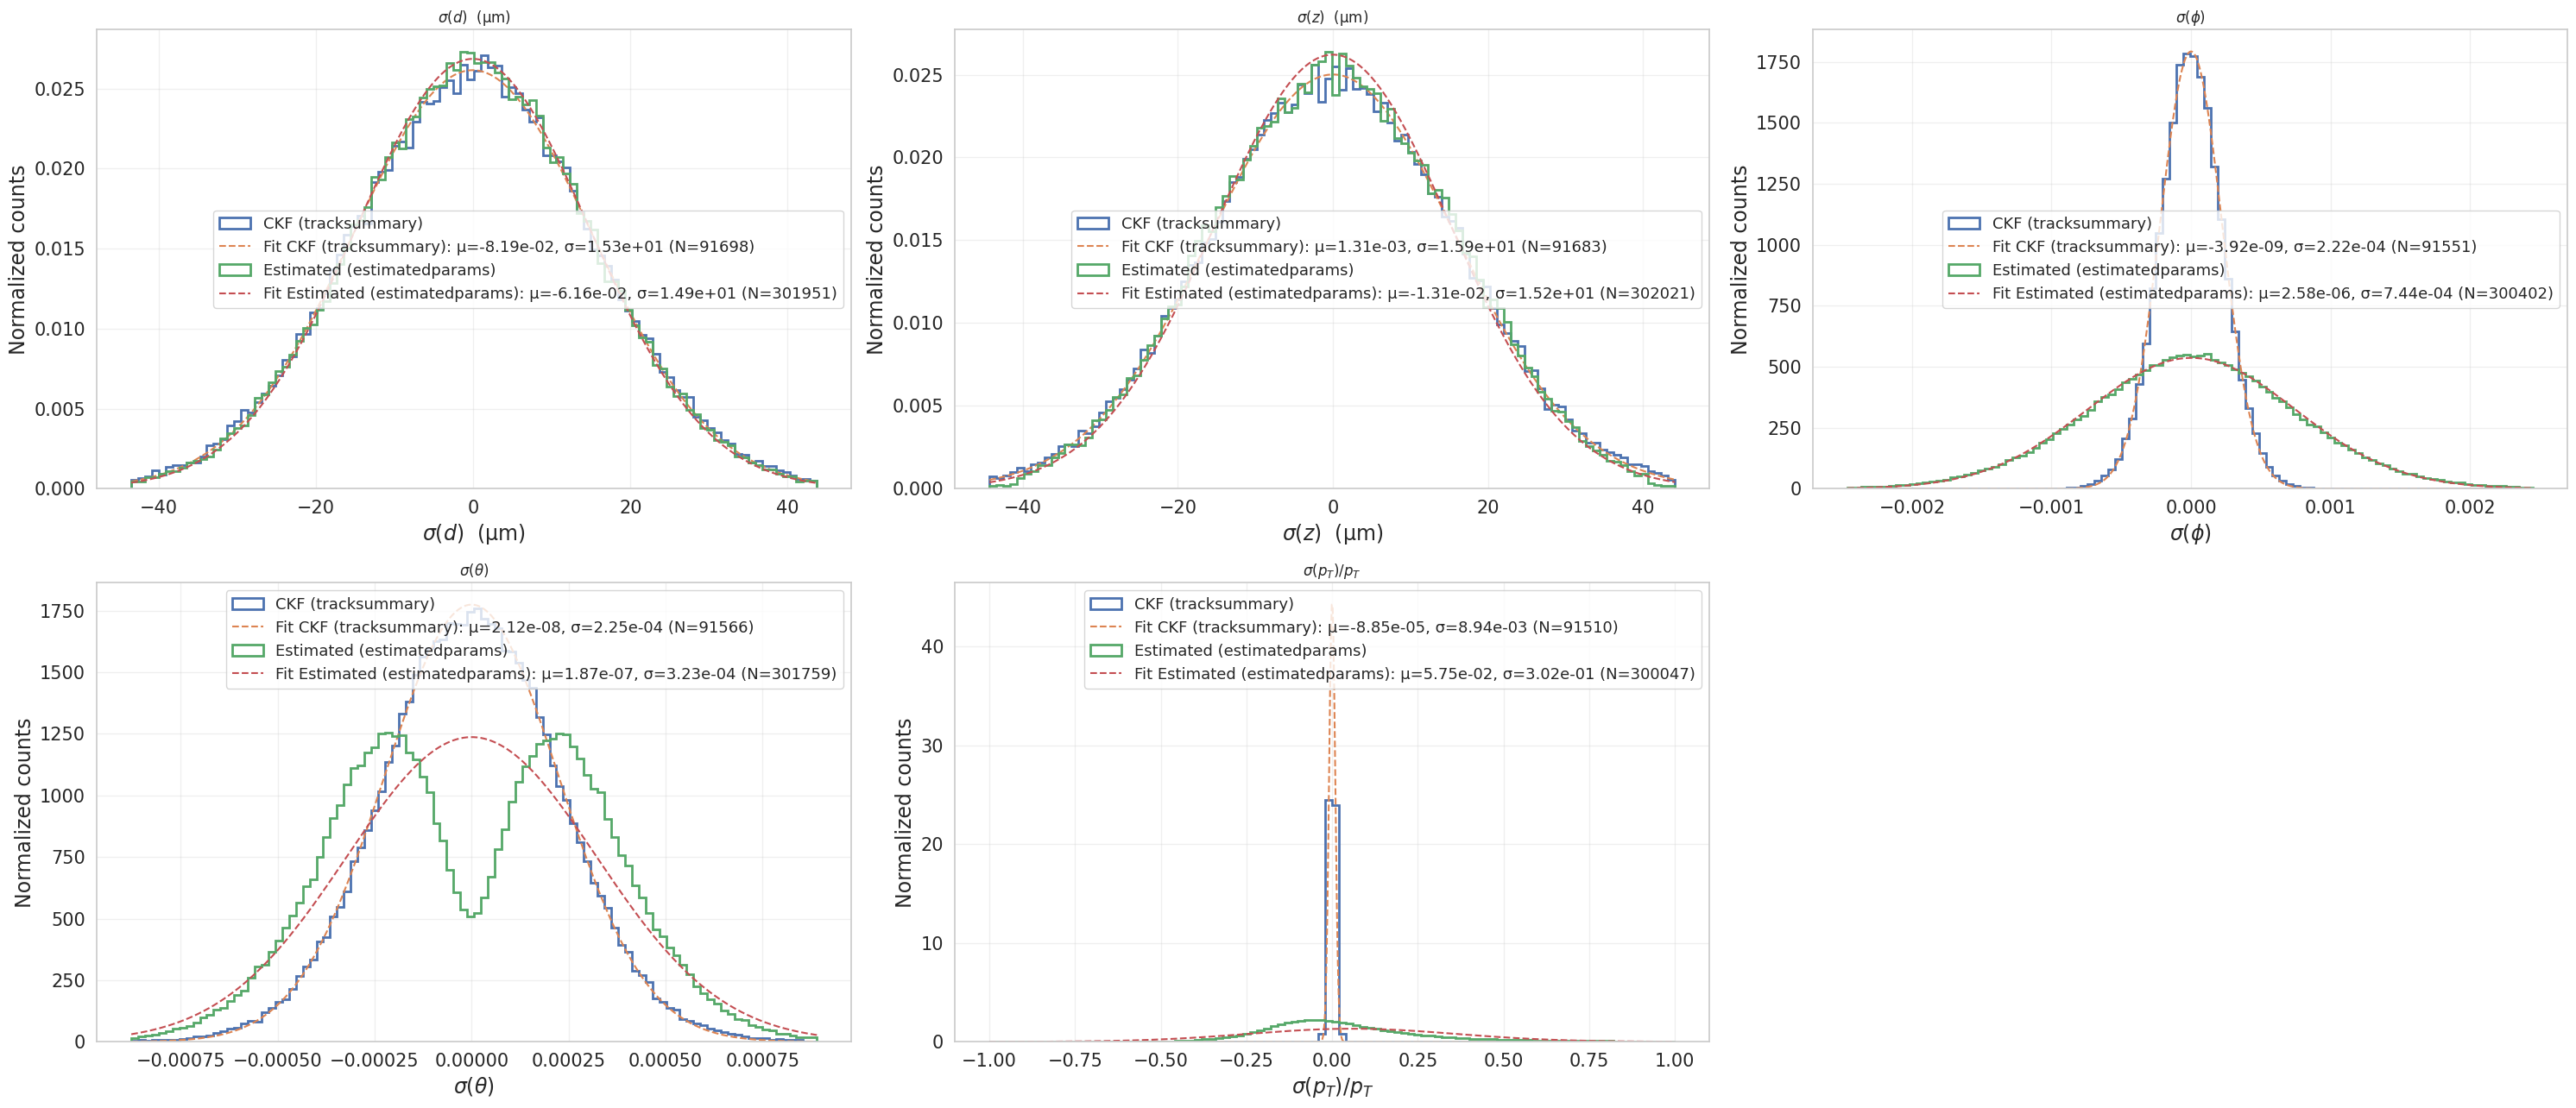

In [21]:
def plot_compare(varname, a, b, nbins=100, fixed_ranges=None, title_map=None, outdir=None):
    labelA = "CKF (tracksummary)"
    labelB = "Estimated (estimatedparams)"

    if fixed_ranges and (varname in fixed_ranges):
        lo, hi = fixed_ranges[varname]
    else:
        lo, hi = common_hist_range(a, b)

    muA, sdA, nA = robust_norm_fit(a)
    muB, sdB, nB = robust_norm_fit(b)
    xgrid = np.linspace(lo, hi, 800)

    plt.subplot(230 + i)
    if a.size:
        plt.hist(a, bins=nbins, range=(lo,hi), histtype='step', density=True, linewidth=2, label=f"{labelA}")
        if np.isfinite(sdA) and sdA>0:
            plt.plot(xgrid, norm.pdf(xgrid, muA, sdA), linestyle='--', label=f"Fit {labelA}: μ={muA:.2e}, σ={sdA:.2e} (N={nA})")
    if b.size:
        plt.hist(b, bins=nbins, range=(lo,hi), histtype='step', density=True, linewidth=2, label=f"{labelB}")
        if np.isfinite(sdB) and sdB>0:
            plt.plot(xgrid, norm.pdf(xgrid, muB, sdB), linestyle='--', label=f"Fit {labelB}: μ={muB:.2e}, σ={sdB:.2e} (N={nB})")

    ttl = title_map.get(varname, varname) if title_map else varname
    plt.title(ttl)
    plt.xlabel(ttl)
    plt.ylabel("Normalized counts")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    if outdir:
        os.makedirs(outdir, exist_ok=True)
        fname = os.path.join(outdir, f"compare_{varname.replace('/','_')}.png")
        plt.savefig(fname, dpi=160)
        print("saved:", fname)

# Plotting
plt.figure(figsize=(30, 13))
i = 0
for var in ["sigma(d)","sigma(z)","sigma(phi)","sigma(theta)","sigma(pt)/pt"]:
    i += 1
    a = data_ckf[var]
    b = data_est[var]
    plot_compare(var, a, b, nbins=NBINS, fixed_ranges=FIXED_RANGES, title_map=TITLES, outdir=OUTDIR)
